### Prep data for logistic regression

In [48]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
from snowflake.ml.modeling.preprocessing import *
from snowflake.ml.modeling.impute import *
import seaborn as sns
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder



In [49]:
with open('creds.json') as f:
    connection_parameters = json.load(f)

In [50]:
session = Session.builder.configs(connection_parameters).create()
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database and schema: "MUSHROOMS_DB"."PUBLIC"
Current Warehouse: "MUSHROOM_M_WH"


In [51]:
snowpark_df = session.table("MUSHROOM_DB.PUBLIC.MUSHROOMS") # add full path to table db.shema.table
print(type(snowpark_df))



<class 'snowflake.snowpark.table.Table'>


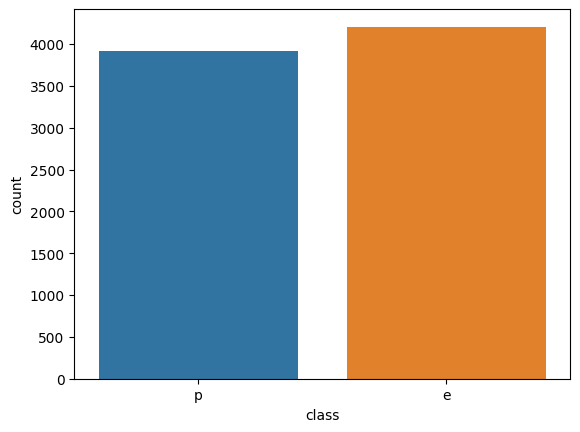

In [52]:
# Convert Snowpark DataFrame to pandas DataFrame
pandas_df = snowpark_df.toPandas()

# Visualize the distribution of classes
sns.countplot(x='class', data=pandas_df)
plt.show()

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [54]:
# Encode the target variable 'class' (p/e)
le = LabelEncoder()
pandas_df['class'] = le.fit_transform(pandas_df['class'])

# Separate features (X) and target variable (y)
X = pandas_df.drop('class', axis=1)
y = pandas_df['class']

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [55]:
print("Training Set:")
print("X_train Rows:", X_train.shape[0])
print("X_train Columns:", X_train.shape[1])
print("y_train Rows:", y_train.shape[0])

# Display the row and column counts for the testing set
print("\nTesting Set:")
print("X_test Rows:", X_test.shape[0])
print("X_test Columns:", X_test.shape[1])
print("y_test Rows:", y_test.shape[0])

Training Set:
X_train Rows: 6499
X_train Columns: 95
y_train Rows: 6499

Testing Set:
X_test Rows: 1625
X_test Columns: 95
y_test Rows: 1625


In [56]:
# Create and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [57]:
# Evaluate the model on the test set
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Classifier:
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       843
           1       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Confusion Matrix:
 [[843   0]
 [  0 782]]


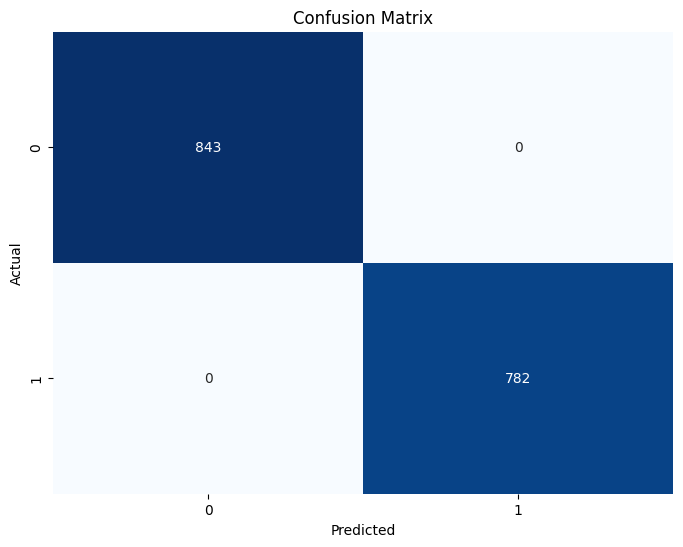

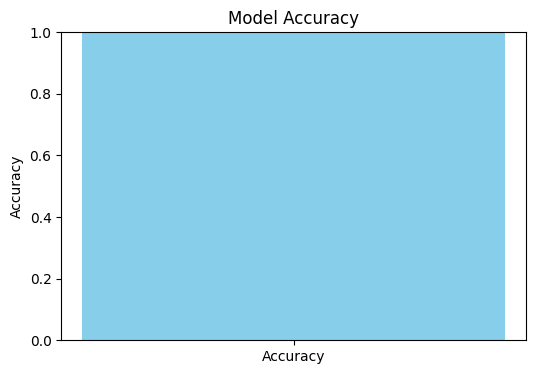

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming you have already trained the Random Forest model and made predictions
# rf_model.fit(X_train, y_train)
# y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plotting the Accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Accuracy'], [accuracy], color='skyblue')
plt.ylim(0, 1)  # Assuming accuracy is in the range [0, 1]
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.show()
